## Import and params

In [ ]:
import os

import numpy as np
import torch
from tqdm import tqdm
import pprint
import rasterio

LABEL_FILENAME = "y.tif"

## Dataloader

In [2]:
def get_dates(path, n=None):
    """
    extracts a list of unique dates from dataset sample

    :param path: to dataset sample folder
    :param n: choose n random samples from all available dates
    :return: list of unique dates in YYYYMMDD format
    """

    files = os.listdir(path)
    dates = list()
    for f in files:
        f = f.split("_")[0]
        if len(f) == 8:  # 20160101
            dates.append(f)

    dates = set(dates)

    if n is not None:
        dates = random.sample(dates, n)

    dates = list(dates)
    dates.sort()
    return dates


def read_classes(csv):
    with open(csv, 'r') as f:
        classes = f.readlines()

    ids = list()
    names = list()
    reliable_start_grow = list()
    reliable_end_grow = list()
    unreliable_start_grow = list()
    unreliable_end_grow = list()
    for row in classes:
        row = row.replace("\n", "")
        if '|' in row:
            cls_info = row.split('|')
            # we can have multiple id
            id_info = cls_info[0].split(',')
            id_info = [int(x) for x in id_info]
            # ids.append(int(cls_info[0]))
            ids.append(id_info)
            names.append(cls_info[1])
            if len(cls_info) > 2:
                reliable_start_grow.append(cls_info[2])
                reliable_end_grow.append(cls_info[3])
            if len(cls_info) > 4:
                unreliable_start_grow.append(cls_info[2])
                unreliable_end_grow.append(cls_info[3])

    return ids, names, reliable_start_grow, reliable_end_grow, \
           unreliable_start_grow, unreliable_end_grow
           
   
def get_patch_id(samples, idx_img):
    _path = samples[idx_img]
    if _path.endswith(os.sep):
        _path = _path[:-1]
    _id = os.path.basename(_path)
    return _id, _path


def read(file):
    with rasterio.open(file) as src:
        return src.read(), src.profile
    

def get_all_dates(path, num_max_dates, consecutive=False):
    """
    extracts a list of unique dates from dataset sample

    Args:
        param path: to dataset sample folder
        param num_max_dates: choose num_max_dates random samples from all available dates
        consecutive: if True and num_max_dates < len(dates) then extracts consecutive dates else random
    return: list of unique dates in YYYYMMDD format
    """
    files = os.listdir(path)
    dates = list()
    for f in files:
        f = f.split("_")[0]
        if len(f) == 8:  # f=20160101
            dates.append(f)

    dates = set(dates)
    if num_max_dates < len(dates):
        if not consecutive:
            dates = random.sample(dates, num_max_dates)
        else:  # extracts consecutive dates
            dates = list(dates)
            dates.sort()
            diff = (len(dates) - num_max_dates)
            start = diff // 2
            stop = num_max_dates + start
            subdates = dates[start:stop]
            return subdates

    dates = list(dates)
    dates.sort()
    return dates


def labels_to_ids(ref_date, label, classids, start_grow=list(), stop_grow=list()):
    new = np.zeros(label.shape, int)
    data = date2int(ref_date)
    for cl, i in zip(classids, range(len(classids))):
        if isinstance(cl, int):
            cl = [cl]
        if len(start_grow) > 0:
            date_start = date2int(start_grow[i])
            date_stop = date2int(stop_grow[i])
            if date_start < date_stop:  # same year
                for c in cl:
                    new[label == c] = i if date_start < data < date_stop else 0
            else:  # different years: date_start is in the previous year
                for c in cl:
                    new[label == c] = i if data > date_start or data < date_stop else 0
        else:
            for c in cl:
                new[label == c] = i
    return new


def date2int(date):
    """ Ignore the year and transform the date into an int.
        Ex.
        20160205 -->  205
        20161005 --> 1005
    """
    assert (len(date) == 8)
    return int(date[4:])


def get_sliding_window(pos, x_annual_time_series, win_size):
    # x_annual_time_series to sliding window
    sw_stop = pos + 1
    sw_start = sw_stop - win_size
    if sw_start < 0:
        # batch, channels, time_series, H, W = x_annual_time_series.shape
        channels, time_series, H, W = x_annual_time_series.shape
        # x_win = torch.zeros(batch, channels, win_size, H, W)
        x_win = torch.zeros(channels, win_size, H, W)
        # x_win[:, :, -sw_stop:, :, :] = x_annual_time_series[:, :, :sw_stop, :, :]
        x_win[:, -sw_stop:, :, :] = x_annual_time_series[:, :sw_stop, :, :]
    else:
        # x_annual[batch, channels, time_series, H, W]
        # x_win = x_annual_time_series[:, :, sw_start:sw_stop, :, :]
        x_win = x_annual_time_series[:, sw_start:sw_stop, :, :]
    return x_win

            
class SentinelDailyAnnualDataset(torch.utils.data.Dataset):
    '''
    If the first label is for example "1|unknown" then this will be replaced with a 0 (zero).
    If you want to ignore other labels, then remove them from the classes.txt file and
    this class will assigne label 0 (zero).
    '''

    def __init__(self, root_dirs, years, classes_path, max_seq_length, win_size, tileids=None, stride=1, consecutive=False):
        self.max_seq_length = max_seq_length
        self.win_size = win_size
        self.stride = stride
        self.consecutive = consecutive
        # labels read from groudtruth files (y.tif)
        # useful field to check the available labels
        self.unique_labels = np.array([], dtype=float)
        self.reliable_start_grow = list()
        self.reliable_stop_grow = list()
        self.unreliable_start_grow = list()
        self.unreliable_stop_grow = list()
        cls_info = read_classes(classes_path)
        self.classids = cls_info[0]
        self.classes = cls_info[1]
        if len(cls_info[2]) > 0:
            self.reliable_start_grow = cls_info[2]
            self.reliable_stop_grow = cls_info[3]
        if len(cls_info[4]) > 0:
            self.unreliable_start_grow = cls_info[4]
            self.unreliable_stop_grow = cls_info[5]

        if type(years) is not list:
            years = [years]
        self.data_dirs = years

        if type(root_dirs) is not list:
            root_dirs = [root_dirs]
        self.root_dirs = [r.rstrip("/") for r in root_dirs]
        self.name = ""
        self.samples = list()
        self.ndates = list()
        for root_dir in self.root_dirs:
            print("Reading dataset info:", root_dir)
            self.name += os.path.basename(root_dir) + '_'

            for d in self.data_dirs:
                if not os.path.isdir(os.path.join(root_dir, d)):
                    sys.exit('The directory '+os.path.join(root_dir, d)+" does not exist!")

            stats = dict(
                rejected_nopath=0,
                rejected_length=0,
                total_samples=0)

            dirs = []
            if tileids is None:
                # files = os.listdir(self.data_dirs)
                for d in self.data_dirs:
                    dirs_name = os.listdir(os.path.join(root_dir, d))
                    dirs_path = [os.path.join(root_dir, d, f) for f in dirs_name]
                    dirs.extend(dirs_path)
            else:
                # tileids e.g. "tileids/train_fold0.tileids" path of line separated tileids specifying
                with open(os.path.join(root_dir, tileids), 'r') as f:
                    files = [el.replace("\n", "") for el in f.readlines()]
                for d in self.data_dirs:
                    dirs_path = [os.path.join(root_dir, d, f) for f in files]
                    dirs.extend(dirs_path)

            for path in tqdm(dirs):

                if not os.path.exists(path):
                    stats["rejected_nopath"] += 1
                    continue
                if not os.path.exists(os.path.join(path, LABEL_FILENAME)):
                    stats["rejected_nopath"] += 1
                    continue
                ndates = len(get_dates(path))

                stats["total_samples"] += 1
                self.samples.append(path)
                self.ndates.append(ndates)

            pprint.pprint(stats)

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx_img):
        patch_id, path = get_patch_id(self.samples, idx_img)

        label, profile = read(os.path.join(path, LABEL_FILENAME))

        # unique consecutive dates sorted ascending inside a random window
        dates = get_all_dates(path, self.max_seq_length, consecutive=self.consecutive)

        x_annual = list()

        for date in dates:
            x10_img, profile = read(os.path.join(path, date + ".tif"))
            x_annual.append(x10_img)

        # replace stored ids available in classes csv with indexes
        label = label[0]
        self.unique_labels = np.unique(np.concatenate([label.flatten(), self.unique_labels]))
        y_annual = labels_to_ids(dates[-1], label, self.classids)
        y_dailies = list()
        for idx_date in range(len(dates)):
            if len(self.unreliable_stop_grow) > 0:
                y_daily = labels_to_ids(dates[idx_date], label, self.classids, self.reliable_start_grow, self.unreliable_stop_grow)
            else:
                y_daily = labels_to_ids(dates[idx_date], label, self.classids, self.reliable_start_grow, self.reliable_stop_grow)
            y_dailies.append(y_daily)

        # padding
        padding_size = max(0, self.max_seq_length - len(dates))
        for i in range(padding_size):
            y_dailies.append(np.zeros_like(y_dailies[0]))
            x_annual.append(np.zeros_like(x_annual[0]))
            dates.append(dates[-1][:4] + '1231')
        # dates = np.pad(dates, (0, padding_size - 1), mode='edge')  # padding with mirror

        x_annual = np.array(x_annual) * 1e-4
        x_annual = torch.from_numpy(x_annual)
        y_dailies = torch.from_numpy(np.array(y_dailies))
        y_annual = torch.from_numpy(y_annual)

        # if torch.min(y_annual).item() == 0:
        #     print("0 label")
        #     labels_to_ids(dates[-1], label, self.classids)
        # permute channels with time_series (t x c x h x w) -> (c x t x h x w)
        x_annual = x_annual.permute(1, 0, 2, 3)

        x_annual = x_annual.float()
        y_annual = y_annual.long()
        y_dailies = y_dailies.long()

        # create sliding windows from x_annual
        x_dailies = list()
        for i in range(len(dates)):
            x_win = get_sliding_window(i, x_annual, self.win_size)
            x_dailies.append(x_win)
        x_dailies = torch.stack(x_dailies)

        # simple stride (can be obtimized)
        if self.stride > 1:
            x_dailies = x_dailies[::self.stride, :, :, :, :]
            y_dailies = y_dailies[::self.stride, :, ]
            dates = dates[::self.stride]


        # return x_dailies, y_annual, y_dailies, dates, patch_id
        return x_dailies, y_annual, y_dailies, dates, path


In [3]:
    dataset = SentinelDailyAnnualDataset(
        ["/kaggle/input/sentinel2-crop-mapping/lombardia",
         "/kaggle/input/sentinel2-crop-mapping/lombardia2"],
        ["data2016"],
        "/kaggle/input/sentinel2-crop-mapping/lombardia-classes/classes25pc.txt",
        71, # max_seq_length
        7,  # win_size
        tileids="tileids/train_small.tileids"
    )

    dataloader = torch.utils.data.DataLoader(
        dataset, batch_size=2, shuffle=True, num_workers=8)

    # for data in dataloader:
    #     print(len(data))
        
    x_dailies, y_annual, y_dailies, dates, patch_id = next(iter(dataloader))
    print("x_dailies", x_dailies.shape)
    print("y_annual", y_annual.shape)
    print("y_dailies", y_dailies.shape)
    print("dates", len(dates))
    print("dates[0]", dates[0])
    print("patch_id", patch_id)

Reading dataset info: /kaggle/input/sentinel2-crop-mapping/lombardia


100%|██████████| 10/10 [00:00<00:00, 33.10it/s]


{'rejected_length': 0, 'rejected_nopath': 0, 'total_samples': 10}
Reading dataset info: /kaggle/input/sentinel2-crop-mapping/lombardia2


100%|██████████| 10/10 [00:00<00:00, 31.90it/s]
/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


{'rejected_length': 0, 'rejected_nopath': 0, 'total_samples': 10}
x_dailies torch.Size([2, 71, 9, 7, 48, 48])
y_annual torch.Size([2, 48, 48])
y_dailies torch.Size([2, 71, 48, 48])
dates 71
dates[0] ('20160110', '20160103')
patch_id ('/kaggle/input/sentinel2-crop-mapping/lombardia/data2016/3091', '/kaggle/input/sentinel2-crop-mapping/lombardia2/data2016/24')


## Plot some images

In [4]:
import matplotlib.pyplot as plt

Load and show multispectral image

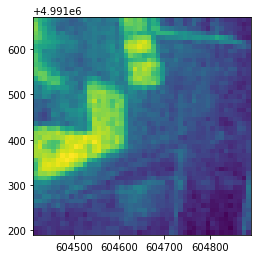

<AxesSubplot:>

In [5]:
from rasterio.plot import show

fp = r'/kaggle/input/sentinel2-crop-mapping/lombardia/data2016/1/20160608.tif'
img = rasterio.open(fp)
show(img)

Load and show labels image

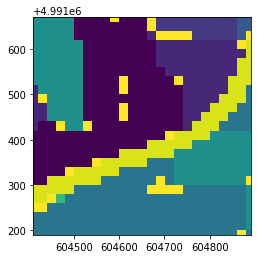

<AxesSubplot:>

In [6]:
fp = r'/kaggle/input/sentinel2-crop-mapping/lombardia/data2016/1/y.tif'
img = rasterio.open(fp)
show(img)